In [1]:
%pylab inline


import os
import cv2
import time
import numpy as np
import pandas as pd
import sys
from sklearn.cluster import KMeans

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import gc
gc.collect()


torch.cuda.empty_cache() 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:

print(os.getcwd())
home_dir = os.path.abspath('../../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
print(data_dir)

print(home_dir)

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

/home/jbang36/eva/others/jupyter/compression
/home/jbang36/eva/data/ua_detrac/DETRAC-Images
/home/jbang36/eva


In [3]:
import sys
print(sys.executable)

/nethome/jbang36/anaconda3/envs/eva_37/bin/python


In [3]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")


def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)


  0%|          | 7/10427 [00:00<02:36, 66.73it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10427


100%|██████████| 10427/10427 [01:16<00:00, 136.70it/s]
1it [00:00,  2.58it/s]

MVI_20011.xml
mvi length: 665
car_labels length: 665


2it [00:00,  2.58it/s]

MVI_20012.xml
mvi length: 1602
car_labels length: 1602
MVI_20032.xml
mvi length: 2040
car_labels length: 2040


4it [00:01,  3.20it/s]

MVI_20033.xml
mvi length: 2825
car_labels length: 2825


5it [00:01,  3.05it/s]

MVI_20034.xml
mvi length: 3625
car_labels length: 3625


6it [00:01,  2.70it/s]

MVI_20035.xml
mvi length: 4425
car_labels length: 4425


7it [00:02,  2.67it/s]

MVI_20051.xml
mvi length: 5332
car_labels length: 5332


8it [00:02,  2.74it/s]

MVI_20052.xml
mvi length: 6026
car_labels length: 6026


9it [00:02,  2.72it/s]

MVI_20061.xml
mvi length: 6826
car_labels length: 6826


10it [00:03,  3.06it/s]

MVI_20062.xml
mvi length: 7626
car_labels length: 7626


11it [00:03,  3.21it/s]

MVI_20063.xml
mvi length: 8426
car_labels length: 8426


12it [00:04,  2.50it/s]

MVI_20064.xml
mvi length: 9226
car_labels length: 9226


13it [00:04,  2.10it/s]

MVI_20065.xml
mvi length: 10427
car_labels length: 10427
Total time to load small data is 81.06516695022583 seconds


In [4]:

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image_fixed(X, height, width):
    n_samples,_,_,channels = X.shape
    X_new = np.ndarray(shape=(n_samples, height, width, channels))
    for i in range(n_samples):
        X_new[i] = cv2.resize(X[i],  (width,height))
    
    X_new /= 255.0
        
    return X_new


def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image_fixed(X_train_norm, 40, 80)
X_test_norm = _format_image_fixed(X_test_norm, 40, 80)

In [5]:
# Create CAE with pytorch 


class cae(nn.Module):
    def __init__(self,h,w):
        super(cae, self).__init__()
        self.input_channels = 3
        self.output_channels = 3
        self.build(h,w)
        
    def forward(self, x):
        x1 = self.enc(x)
        n,c,h,w = x1.size()
        x2 = self.linear_f(x1.view(n,1,-1))
        x3 = self.linear_b(x2)
        x4 = self.dec(x3.view(n,c,h,w))
        
        return x2, x4

        
    def build(self, h,w):
        
        self.linear_f = nn.Linear(int(16*h/4*w/4), 255)
        self.linear_b = nn.Linear(255, int(16*h/4*w/4))
        
        self.enc = nn.Sequential()
        self.enc.add_module('Conv1_1', nn.Conv2d(self.input_channels, 8, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_2', nn.ReLU(True))
        self.enc.add_module('Conv1_3', nn.Conv2d(8,8,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_4', nn.ReLU(True))
        self.enc.add_module('Max1_5', nn.MaxPool2d(2, stride = 2))
        self.enc.add_module('Conv2_1', nn.Conv2d(8, 16, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_2', nn.ReLU(True))
        self.enc.add_module('Conv2_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_4', nn.ReLU(True))
        self.enc.add_module('Max2_5', nn.MaxPool2d(2, stride = 2))
        
        self.dec = nn.Sequential()
        self.dec.add_module('CT3_1', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv3_2', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_3', nn.ReLU(True))
        self.dec.add_module('Conv3_4', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_5', nn.ReLU(True))
        self.dec.add_module('CT4_1', nn.ConvTranspose2d(16, 8, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv4_2', nn.Conv2d(8, 8, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_3', nn.ReLU(True))
        self.dec.add_module('Conv4_4', nn.Conv2d(8, self.output_channels, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_5', nn.ReLU(True))
        
        
        



In [6]:
        

# Loss Function Revision

batch_size = 512
n_samples, H, W, C = X_train_norm.shape
cae = cae(H,W).cuda()
distance = nn.MSELoss()


train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)


In [10]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
total_epochs = 150



optimizer = torch.optim.Adam(cae.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
losses = []
for epoch in range(total_epochs):    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        compressed, recon = cae(images_cuda)  
        optimizer.zero_grad()
        loss2 = distance(recon, images_cuda)
        loss2.backward()
        optimizer.step()

    print('epoch [{}/{}], loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss2.data, time.perf_counter() - st))
    losses.append(loss2.data)

epoch [1/150], loss2:0.0219, time elapsed:3.2298 (sec)
epoch [2/150], loss2:0.0217, time elapsed:3.0637 (sec)
epoch [3/150], loss2:0.0220, time elapsed:3.1134 (sec)
epoch [4/150], loss2:0.0217, time elapsed:3.1410 (sec)
epoch [5/150], loss2:0.0216, time elapsed:3.2428 (sec)
epoch [6/150], loss2:0.0217, time elapsed:3.1435 (sec)
epoch [7/150], loss2:0.0216, time elapsed:3.0754 (sec)
epoch [8/150], loss2:0.0214, time elapsed:3.1418 (sec)
epoch [9/150], loss2:0.0212, time elapsed:3.0505 (sec)
epoch [10/150], loss2:0.0211, time elapsed:3.0548 (sec)
epoch [11/150], loss2:0.0212, time elapsed:3.0799 (sec)
epoch [12/150], loss2:0.0214, time elapsed:3.0346 (sec)
epoch [13/150], loss2:0.0208, time elapsed:2.9536 (sec)
epoch [14/150], loss2:0.0209, time elapsed:2.9269 (sec)
epoch [15/150], loss2:0.0204, time elapsed:3.0075 (sec)
epoch [16/150], loss2:0.0200, time elapsed:3.0255 (sec)
epoch [17/150], loss2:0.0194, time elapsed:3.0106 (sec)
epoch [18/150], loss2:0.0187, time elapsed:3.0760 (sec)
e

In [11]:
X_test_torch = torch.from_numpy(X_test_norm[0:10]).float()
test_data = X_test_torch.permute(0,3,1,2)
test_cuda = test_data.cuda()
compressed, recon = cae(test_cuda)

recon_p = recon.permute(0,2,3,1)
print(recon_p.size())
recon_imgs = recon_p.detach().cpu().numpy()
recon_imgs *= 255
recon_imgs = recon_imgs.astype(np.uint8)



torch.Size([10, 40, 80, 3])


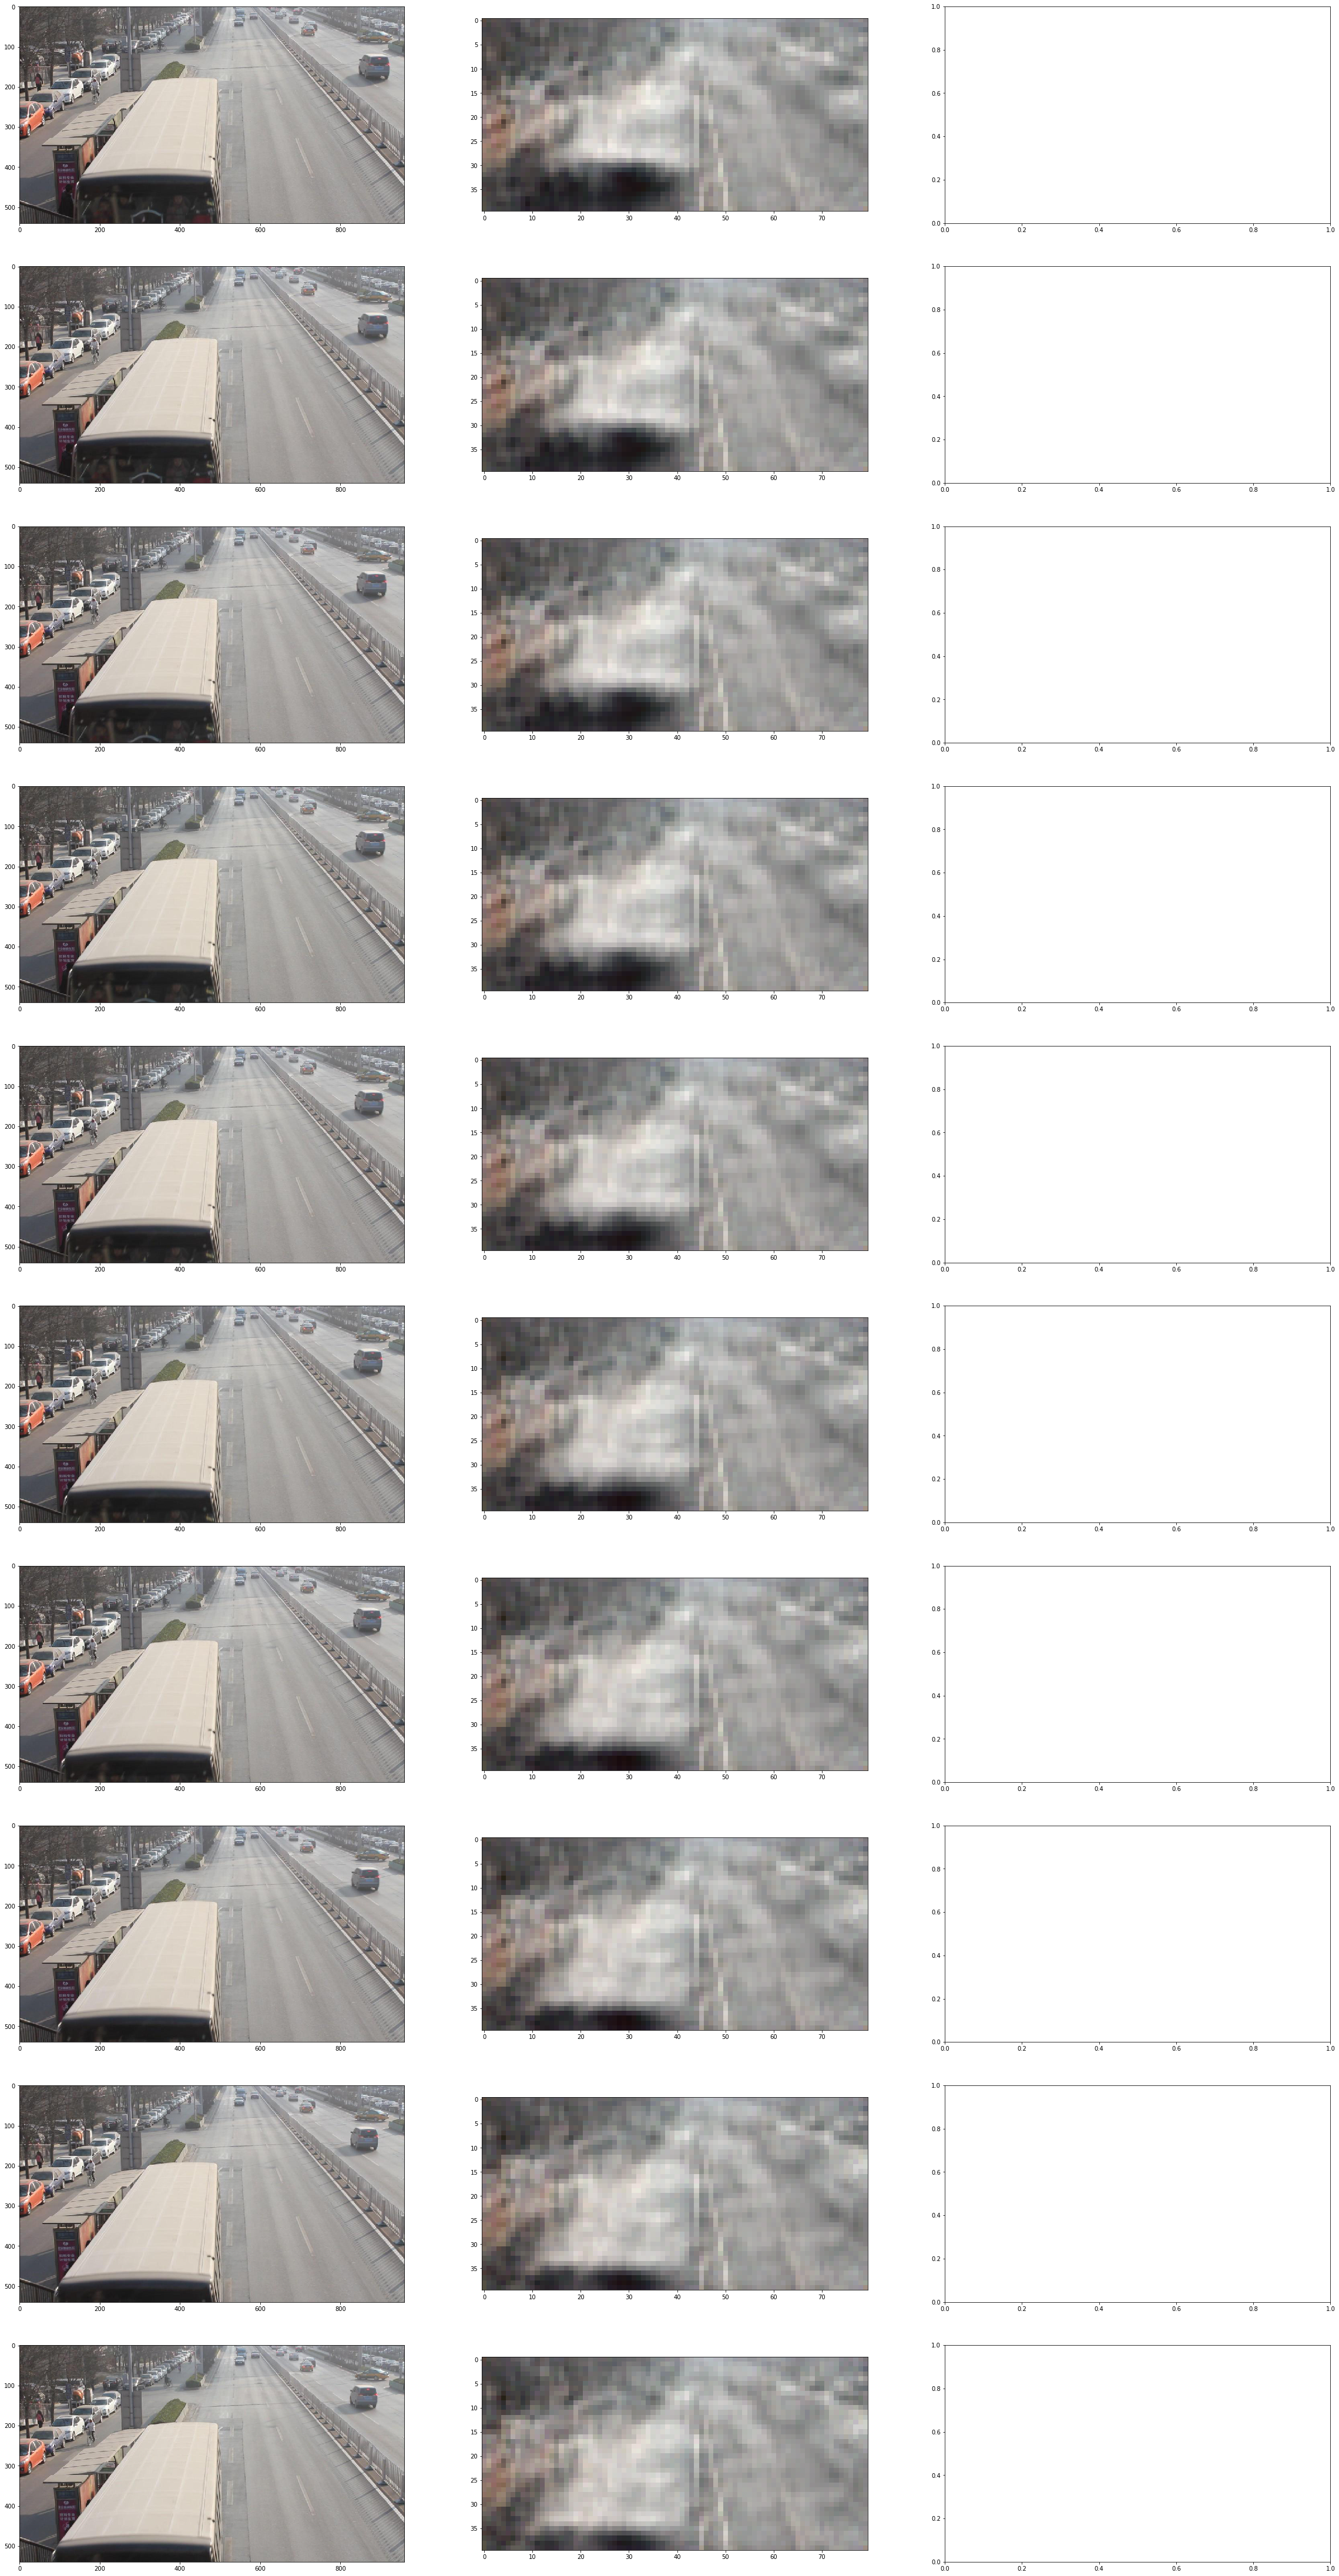

In [12]:

fig = plt.figure(figsize=(40,80))
columns = 3
rows = 10
for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows,columns,i*columns + j + 1)
        if j == 0:     
            plt.imshow(X_test[i,:,:,:])
        if j == 1:
            plt.imshow(recon_imgs[i])
    
plt.show()

In [86]:
## Create CAE_lstm
## Train and see results


class cae_lstm(nn.Module):
    def __init__(self,n,h,w):
        super(cae_lstm, self).__init__()
        self.input_channels = 3
        self.output_channels = 3
        self.seq_length = 16
        self.build(n,h,w)
        
    def forward(self, x):
        x1 = self.enc(x)
        n,c,h,w = x1.size()
        print(n,c,h,w)
        x2, (self.hidden_f, self.cell_f) = self.lstm_f(x1.view(n,c*h*w).view(self.seq_length,int(n / self.seq_length),c*h*w), (self.hidden_f, self.cell_f))
        print(x2.size())
        x3, (self.hidden_b, self.cell_b) = self.lstm_b(x2, (self.hidden_b, self.cell_b))
        print(x3.size())
        x4 = self.dec(x3.view(n,c*h*w).view(n,c,h,w))
        
        return x2, x4

        
    def build(self, n, h,w):
        
        self.lstm_f = nn.LSTM(int(16*h/4*w/4), 255)
        self.lstm_b = nn.LSTM(255, int(16*h/4*w/4))
        self.hidden_f = torch.randn(1,int(n / self.seq_length), 255).cuda()
        self.cell_f = torch.randn(1,int(n / self.seq_length), 255).cuda()
        self.hidden_b = torch.randn(1,int(n / self.seq_length) ,int(16*h/4*w/4)).cuda()
        self.cell_b = torch.randn(1,int(n / self.seq_length), int(16*h/4*w/4)).cuda()
        
        self.enc = nn.Sequential()
        self.enc.add_module('Conv1_1', nn.Conv2d(self.input_channels, 8, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_2', nn.ReLU(True))
        self.enc.add_module('Conv1_3', nn.Conv2d(8,8,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_4', nn.ReLU(True))
        self.enc.add_module('Max1_5', nn.MaxPool2d(2, stride = 2))
        self.enc.add_module('Conv2_1', nn.Conv2d(8, 16, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_2', nn.ReLU(True))
        self.enc.add_module('Conv2_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_4', nn.ReLU(True))
        self.enc.add_module('Max2_5', nn.MaxPool2d(2, stride = 2))
        
        self.dec = nn.Sequential()
        self.dec.add_module('CT3_1', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv3_2', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_3', nn.ReLU(True))
        self.dec.add_module('Conv3_4', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_5', nn.ReLU(True))
        self.dec.add_module('CT4_1', nn.ConvTranspose2d(16, 8, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv4_2', nn.Conv2d(8, 8, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_3', nn.ReLU(True))
        self.dec.add_module('Conv4_4', nn.Conv2d(8, self.output_channels, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_5', nn.ReLU(True))
        
        
   



In [87]:
# train_loader need to feed in data sequentially


batch_size = 512
n_samples, H, W, C = X_train_norm.shape
cae_lstm = cae_lstm(batch_size,H,W).cuda()
distance = nn.MSELoss()


train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=1, drop_last=True)


In [91]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
total_epochs = 150



optimizer = torch.optim.Adam(cae_lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
lstm_losses = []
for epoch in range(total_epochs):
 #   if epoch % 1000 == 0:
 #       optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        compressed, recon = cae_lstm(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        
        loss2 = distance(recon, images_cuda)
        loss2.backward(retain_graph=True)
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")

    print('epoch [{}/{}], loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss2.data, time.perf_counter() - st))
    lstm_losses.append(loss2.data)

512 16 10 20
torch.Size([16, 32, 255])
torch.Size([16, 32, 3200])


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [27]:
X_test_torch = torch.from_numpy(X_test_norm[0:10]).float()
test_data = X_test_torch.permute(0,3,1,2)
test_cuda = test_data.cuda()
print(test_data.size())
compressed, recon = cae_lstm(test_cuda)



recon_p = recon.permute(0,2,3,1)
print(recon_p.size())
recon_imgs = recon_p.detach().cpu().numpy()
recon_imgs *= 255
recon_imgs = recon_imgs.astype(np.uint8)


torch.Size([10, 3, 40, 80])


RuntimeError: input has inconsistent input_size: got 1, expected 3200

In [ ]:
### What if we can design the network to learn to separate background/moving objects?
# Encoder is 1, but we have 2 decoders
# Frontal part contains information about static image because the loss will be computed against avg image
# The rest will have to contain information about dynamic image because loss will be computed against individual image


class cae_lstm(nn.Module):
    def __init__(self,n,h,w):
        super(cae_lstm, self).__init__()
        self.input_channels = 3
        self.output_channels = 3
        self.build(n,h,w)
        
    def forward(self, x):
        x1 = self.enc(x)
        n,c,h,w = x1.size()
        x2, self.hidden_f = self.lstm_f(x1.view(n,1,-1), self.hidden_f)
        x3, self.hidden_b = self.linear_b(x2, self.hidden_b)
        
        #x3 will be divided into 2 components x3_frontal, x3_hindal
        x3_frontal = x3[n,:200]
        x3_hindal = x3[n, 200:]
        
        x4 = self.dec(x3.view(n,c,h,w))
        
        return x2, x4

        
    def build(self, n, h,w):
        
        self.lstm_f = nn.LSTMCell(int(16*h/4*w/4), 255)
        self.lstm_b = nn.LSTMCell(255, int(16*h/4*w/4))
        self.hidden_f = torch.randn(1,255)
        self.hidden_b = torch.randn(1,int(16*h/4*w/4))
        
        self.enc = nn.Sequential()
        self.enc.add_module('Conv1_1', nn.Conv2d(self.input_channels, 8, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_2', nn.ReLU(True))
        self.enc.add_module('Conv1_3', nn.Conv2d(8,8,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu1_4', nn.ReLU(True))
        self.enc.add_module('Max1_5', nn.MaxPool2d(2, stride = 2))
        self.enc.add_module('Conv2_1', nn.Conv2d(8, 16, kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_2', nn.ReLU(True))
        self.enc.add_module('Conv2_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.enc.add_module('Relu2_4', nn.ReLU(True))
        self.enc.add_module('Max2_5', nn.MaxPool2d(2, stride = 2))
        
        self.dec = nn.Sequential()
        self.dec.add_module('CT3_1', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv3_2', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_3', nn.ReLU(True))
        self.dec.add_module('Conv3_4', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu3_5', nn.ReLU(True))
        self.dec.add_module('CT4_1', nn.ConvTranspose2d(16, 8, kernel_size = 2, stride = 2))
        self.dec.add_module('Conv4_2', nn.Conv2d(8, 8, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_3', nn.ReLU(True))
        self.dec.add_module('Conv4_4', nn.Conv2d(8, self.output_channels, kernel_size=3, padding = (1,1)))
        self.dec.add_module('Relu4_5', nn.ReLU(True))
        
        


In [52]:
############################################
h = 20
w = 40
c = 3
lstm = nn.LSTM(c*h*w, 25)  # Input dim is 3, output dim is 3
inputs = torch.randn(5,c,h,w)
#inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

#print(inputs)

In [50]:

# initialize the hidden state.
#hidden = torch.randn(5,25)
#hidden = (torch.randn(1, 1, 3),
#          torch.randn(1, 1, 3))
#print(hidden)

In [58]:
a,b = lstm(inputs.view(5,1,c*h*w))

c,d = b
print(a.size())
print(c.size())
print(d.size())


#for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
#    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
#inputs = torch.cat(inputs).view(len(inputs), 1, -1)
#hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
#out, hidden = lstm(inputs, hidden)
#print(out)
#print(hidden)

torch.Size([5, 1, 25])
torch.Size([1, 1, 25])
torch.Size([1, 1, 25])
